In [1]:
%matplotlib inline
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
print(torch.__version__)

1.0.1.post2


#### Dataset Class (loads data from csv)

In [2]:
reqd_len = 50
channels = 3
classes = 12
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('../data/train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('../data/test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('../data/val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        y = self.df.iloc[idx : idx + reqd_len, 3 : ].values
        ind = np.argmax(np.sum(y, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        assert(label.shape == (classes, ))
        return x, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(1550250, 15)
(193750, 15)
(193850, 15)


#### DataLoader definitions (provides data in iterable form)

In [3]:
train_batch_size = 16
batch_size = 16
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

In [4]:
def output_size(n, f, p = 0, s = 1):
    ''' Returns output size for given input size (n), filter size (f), padding (p) and stride (s)
    for a convolutional layer
    '''
    return (((n + 2 * p - f) / s) + 1)

output_size(50, 5)
output_size(46, 5)

42.0

#### PyTorch implementation of running Standard Deviation

In [10]:
def running_std_dev(signal, window_size = 10):
    ''' Returns running standard deviation of 3D signal (batch_size, length, channels)
    Output length is window_size less than input length i.e. output shape is (batch_size, length - window_size, channels)
    '''
    mean = torch.zeros((signal.shape[0], signal.shape[1] - window_size, signal.shape[2]))
    if torch.cuda.is_available() : 
        mean = mean.cuda()
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size) : 
            mean[i][j] = signal[i][j : j + window_size].std(dim = 0)
            
#     for i in range(signal.shape[0]) :
#         for j in range(signal.shape[1] - window_size, signal.shape[1]) :
#             mean[i][j] = np.abs(signal[i][j])
            
    return mean

In [14]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 5, 3)
        self.conv2 = nn.Conv1d(5, 10, 3)
        self.fc1 = nn.Linear(36 * 10, 256)
        self.fc2 = nn.Linear(256, 64)
        self.pamap = nn.Linear(64, 12)
        self.robogame = nn.Linear(64, 4)
        
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.pamap.weight, gain = nn.init.calculate_gain('sigmoid'))
        nn.init.xavier_uniform_(self.robogame.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    # use flag = True during fine-tuning 
    def forward(self, signal, flag = False):
        signal = running_std_dev(signal)
        signal = torch.transpose(signal, 1, 2)
        out = F.relu(self.conv1(signal))
        out = F.relu(self.conv2(out))
        out = torch.transpose(out, 1, 2)
        out = out.reshape(-1, 36 * 10)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        if flag : 
            out = F.log_softmax(self.robogame(out), dim = 1)
        else :
            out = F.log_softmax(self.pamap(out), dim = 1)
        return out

Net = ConvNet()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()

Model on GPU


In [15]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

In [ ]:
num_epochs = 100
total_step = len(trainset) // (train_batch_size * reqd_len)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 200 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '../saved_models/model0.pt')

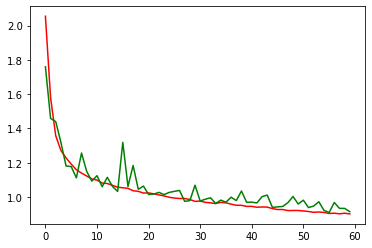

In [18]:
j = np.arange(60)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [13]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float().cuda()
        labels = Variable(labels).float()

        outputs = Net(images)
        
        outputs = outputs.cpu()
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net.cuda()
# _get_accuracy(trainloader)

ConvNet(
  (conv1): Conv1d(3, 5, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(5, 10, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=460, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (pamap): Linear(in_features=64, out_features=12, bias=True)
  (robogame): Linear(in_features=64, out_features=4, bias=True)
)

In [24]:
print(_get_accuracy(trainloader, Net))
print(_get_accuracy(testloader, Net))
print(_get_accuracy(valloader, Net))

0.7127645844088797
0.7110020661157025
0.706353305785124


In [15]:
testing_Net = ConvNet()
testing_Net.load_state_dict(torch.load('../saved_models/model5.pt'))
testing_Net.eval().cuda()
print(_get_accuracy(trainloader, testing_Net) * 100, '/', _get_accuracy(valloader, testing_Net) * 100, '/', _get_accuracy(testloader, testing_Net) * 100)

78.27995867768594 / 78.25413223140497 / 78.150826446281
